# Mamoas Detection
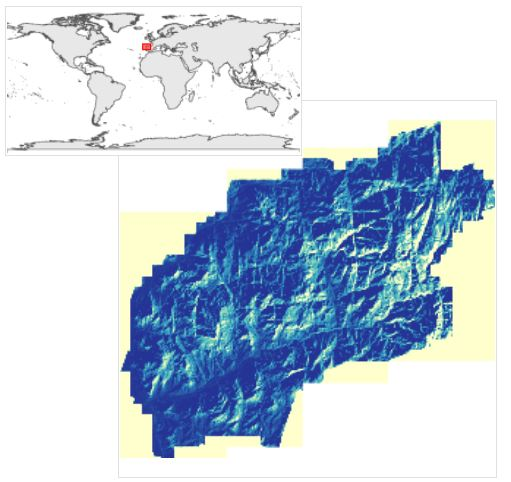

In [ ]:
!python -m pip show tensorflow

In [ ]:
# Import relevant libraries
from tensorflow.keras.layers import Input, Activation, ZeroPadding2D, Lambda, Dense, Flatten,Dropout,Conv2D,MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from keras.utils import np_utils
from keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import glob
import os.path
from pathlib import Path
import shutil
from os.path import exists
import seaborn as sns
import random
import ee
from PIL import Image

## Image Pre-Processing

In [ ]:
# read all images of classes and convert .tif to .jpg format
path = "C:\\Users\\fabri\\Downloads\\folder data\\dataset_cnn\\"
dimention = 40
data = []
width = dimention
height = dimention
dim = (width, height)

labels = ['mamoa', 'not_mamoa']
        
if(os.path.exists(path)):  
    for label in labels:
        p = os.path.join(path, label)
        class_num = labels.index(label)
        for img in os.listdir(p):
          img_array = cv2.imread(os.path.join(p,img), cv2.IMREAD_GRAYSCALE)
          resized = cv2.resize(img_array, dim, interpolation = cv2.INTER_AREA)
          data.append([resized, class_num])
else:
    print("This directory: "+path+" doesn't exist.")
# shuffle the dataset
random.shuffle(data)

# extract the features and label
x = []
y = []
for features, label in data:
    x.append(features)
    y.append(label)

x = np.array(x).reshape(-1, height, width, 1)
y = np.array(y)

# Normalize the values of features
x = x/255

In [ ]:
count = []
for i in range(0, len(data)):
    if (data[i][1] == 0):
        count.append('mamoa')
    else:
        count.append('not_mamoa')

sns.set_style('darkgrid')
sns.countplot(count)

# examples of two classes
#plt.figure(figsize = (5,5))
#plt.imshow(x[2], cmap='gray')
#if y[2] == 0: plt.title('mamoa')
#else: plt.title('not mamoa')

#plt.figure(figsize = (5,5))
#plt.imshow(x[10], cmap='gray')
#if y[10] == 0: plt.title('mamoa')
#else: plt.title('not mamoa')
 

## Train-Test-Val split

In [ ]:
# split the dataset in train, validation and test using 60, 20, 20, respectively  change: 70, 15, 15
x_train,x_test,y_train,y_test=train_test_split(x,y,train_size=0.7, test_size=0.3, random_state=None)
x_test,x_val,y_test,y_val=train_test_split(x_test,y_test,test_size=0.5, random_state=None)

print("train, val, test:",x_train.shape,x_val.shape,x_test.shape)

count = []
for i in range(0, len(y_train)):
    if (y_train[i] == 0):
        count.append('mamoa')
    else:
        count.append('not_mamoa')
sns.set_style('darkgrid')
sns.displot(count).set(title="Train data") 

count = []
for i in range(0, len(y_val)):
    if (y_val[i] == 0):
        count.append('mamoa')
    else:
        count.append('not_mamoa')
sns.set_style('darkgrid')
sns.displot(count).set(title="Validation data") 

count = []
for i in range(0, len(y_test)):
    if (y_test[i] == 0):
        count.append('mamoa')
    else:
        count.append('not_mamoa')
sns.set_style('darkgrid')
sns.displot(count).set(title="Test data") 

## Model Building

In [ ]:
def MamoasModel(input_shape):
    """
    Implementation of the model.
    
    Arguments:
    input_shape -- shape of the images of the dataset
    
    Returns:
    model -- a Model() instance in Keras
    """
    # Use the suggested model in the text above to get started, and run through the whole
    # exercise once. Then come back and add more BLOCKS. 
    

    # BLOCK 1: CONV -> BN -> RELU -> MAXP
    X_input = Input(input_shape)
    X = ZeroPadding2D((3, 3))(X_input)
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2, 2), name='max_pool0')(X)

    # BLOCK 2: CONV -> BN -> RELU -> MAXP
    #X = ZeroPadding2D((3, 3))(X)
    #X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv1')(X)
    #X = BatchNormalization(axis = 3, name = 'bn1')(X)
    #X = Activation('relu')(X)
    #X = MaxPooling2D((2, 2), name='max_pool1')(X)
        
    # BLOCK N3: CONV -> BN -> RELU -> MAXP
    #X = ZeroPadding2D((3, 3))(X)
    #X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv2')(X)
    #X = BatchNormalization(axis = 3, name = 'bn2')(X)
    #X = Activation('relu')(X)
    #X = MaxPooling2D((2, 2), name='max_pool2')(X)
        
    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Flatten()(X)
    X = Dense(1, activation='sigmoid', name='fc')(X)
    
    # Create model.
    model = Model(inputs = X_input, outputs = X, name='Model')
    
    return model

In [ ]:
model = MamoasModel((height, width, 1))
model.compile(optimizer = 'adam', loss='binary_crossentropy', metrics = ["accuracy"])
model.summary()

# plots the model in a nice layout and save it as ".png"
plot_model(model, to_file='model.png')

## Model Evaluation

In [ ]:
early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=100) # patience 20, epoch 200

history=model.fit(x_train,y_train,validation_data=(x_val,y_val),epochs=300,callbacks=[early_stop],shuffle=True)

model.save("model.h5")
print("Saved model")

In [ ]:
plt.plot(history.history['loss'],label='train loss')
plt.plot(history.history['val_loss'],label='val loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.savefig('loss-graph.png')
plt.show()

# accuracies
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.savefig('acc-graph.png')
plt.show()

In [ ]:
#Test the model on train data  
preds = model.evaluate(x = x_train, y = y_train)

print ("Loss = " + str(preds[0]))
print ("Train Accuracy = " + str(preds[1]))
print()

#Test the model on validation data  
preds = model.evaluate(x = x_val, y = y_val)

print ("Loss = " + str(preds[0]))
print ("Validation Accuracy = " + str(preds[1]))
print()

#Test the model on test data  
preds = model.evaluate(x = x_test, y = y_test)

print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))
print()

In [ ]:
y_val_pred = model.predict(x_val)
#y_val_pred=np.argmax(y_val_pred, axis=1)
predict = []
for i in y_val_pred:
    if i[0] >= 0.5:
        predict.append(1)
    else:
        predict.append(0)
y_val_pred = np.array(predict)

target_names = ['mamoa', 'not_mamoa']
print(classification_report(y_val, y_val_pred, target_names = target_names))

conf_matrix = confusion_matrix(y_val, y_val_pred)
conf_matrix = pd.DataFrame(conf_matrix , index = ['0','1'] , columns = ['0','1'])
plt.figure(figsize = (10,10))
sns.heatmap(conf_matrix, cmap= "Blues", linewidth = 1 , annot = True, fmt='g',xticklabels = labels,yticklabels = labels)

In [ ]:
y_test_pred = model.predict(x_test)

#y_test_pred=np.argmax(y_test_pred, axis=1)
predict = []
for i in y_test_pred:
    if i[0] >= 0.5:
        predict.append(1)
    else:
        predict.append(0)
y_test_pred = np.array(predict)

target_names = ['mamoa', 'not mamoa']
print(classification_report(y_test, y_test_pred, target_names = target_names))

conf_matrix = confusion_matrix(y_test, y_test_pred)
conf_matrix = pd.DataFrame(conf_matrix , index = ['0','1'] , columns = ['0','1'])
plt.figure(figsize = (10,10))
sns.heatmap(conf_matrix, cmap= "Blues", linewidth = 1 , annot = True, fmt='g',xticklabels = labels,yticklabels = labels)

# Predict in LRM - Local Relief Model

In [ ]:
model = load_model('model.h5')

In [ ]:
# Authentication of google earth engine to access some files as example the local relief model
ee.Authenticate()
# Initialization of google earth engine
ee.Initialize()

In [ ]:
LRM = ee.Image('users/fabriziobotelho/tiff_files')
geometry = LRM.geometry()
lrm_info = LRM.getInfo()
print(lrm_info) #debug

#geo-coordinates of upper left and lower right corners of LRM image
upper_left = [-8.907277129492169,42.16335245423417]
lower_right = [-8.06051504207768,41.59280385023923]

points = ee.Geometry.MultiPoint([upper_left, lower_right])

In [ ]:
#this function gets the dimention in pixel of LRM image
def getDimentionsImage(img):
  imgDescription = ee.Algorithms.Describe(img)
  w = ee.List(ee.Dictionary(ee.List(ee.Dictionary(imgDescription).get("bands")).get(0)).get("dimensions")).get(0)
  w = w.getInfo()
  h = ee.List(ee.Dictionary(ee.List(ee.Dictionary(imgDescription).get("bands")).get(0)).get("dimensions")).get(1)
  h = h.getInfo()

  return w, h

#this function uses the equations before obtained to convert a geo-coordinate to pixel coordinate
def convert_GeoCoord_to_PixelCoord(geocoordinate, m1, m2, b1, b2):
  x_geo = geocoordinate[0]
  y_geo = geocoordinate[1]
  x = round(x_geo * m1 + b1)
  y = round(y_geo * m2 + b2)
  
  return x, y

#this function is the inverse of the previous function, with it we can get the geo-coordinates that corresponds to the pixel coordinates
def convert_PixelCoord_to_GeoCoord(pixelcoordinate, m1, m2, b1, b2):
  x = pixelcoordinate[0]
  y = pixelcoordinate[1]
  x_geo = (x - b1)/m1
  y_geo = (y - b2)/m2
  
  return x_geo, y_geo

In [ ]:
width, height = getDimentionsImage(LRM)
width, height

In [ ]:
x_geo1 = upper_left[0]
y_geo1 = upper_left[1]
x_geo2 = lower_right[0]
y_geo2 = lower_right[1]

x1 = 0;
y1 = 0;
x2 = width - 1 
y2 = height - 1

#equations to convert geo-coordinates to pixel coordinates
#x = x_geo * m1 + b1
#y = y_geo * m2 + b2

m1 = (x1 - x2)/(x_geo1 - x_geo2)
b1 = x1 - x_geo1 * m1
print('m1:', m1, 'b1:', b1)

m2 = (y1 - y2)/(y_geo1 - y_geo2)
b2 = y1 - y_geo1 * m2
print('m2:', m2, 'b2:', b2)

In [ ]:
# create just a block with mamoas of Arcos de Valdevez region to analyse the model performance

geometria = ee.Geometry.Polygon([[[-8.143058475037481,42.026511966913404],
                                    [-8.0616909823617,42.026511966913404],
                                    [-8.0616909823617,42.082594290923005],
                                    [-8.143058475037481,42.082594290923005],
                                    [-8.143058475037481,42.026511966913404]]])

LRM = LRM.clip(geometria)
upper_left = [-8.143058475037481,42.082594290923005]
lower_right = [-8.0616909823617,42.026511966913404]

points = ee.Geometry.MultiPoint([upper_left, lower_right])
width, height = getDimentionsImage(LRM)
x_geo1 = upper_left[0]
y_geo1 = upper_left[1]
x_geo2 = lower_right[0]
y_geo2 = lower_right[1]

x1 = 0;
y1 = 0;
x2 = width - 1 
y2 = height - 1

#equations to convert geo-coordinates to pixel coordinates
#x = x_geo * m1 + b1
#y = y_geo * m2 + b2

m1 = (x1 - x2)/(x_geo1 - x_geo2)
b1 = x1 - x_geo1 * m1
print('m1:', m1, 'b1:', b1)

m2 = (y1 - y2)/(y_geo1 - y_geo2)
b2 = y1 - y_geo1 * m2
print('m2:', m2, 'b2:', b2)

width, height


In [ ]:
# read shapefile, geocoordinate of archaeologycal objects

# read laboreiro region
shape_lab = ee.FeatureCollection('users/fabriziobotelho/MamoasLaboreiro')
shape_lab = shape_lab.geometry()
coordinates_lab = shape_lab.coordinates().getInfo()
len(coordinates_lab)

In [ ]:
lab_pixel = []
for i in coordinates_lab:
  lab_pixel.append(convert_GeoCoord_to_PixelCoord(i, m1, m2, b1, b2))

#print('geo coordinates:', coordinates_lab)
#print('pixel_coordinates:', lab_pixel) 
print('length:', len(lab_pixel))  


In [ ]:
#this function counts the number of archaeological objects inside the block image, and we just want the images with this objects
def CountNumberOfMamoas(Xmin, Ymin, Xmax, Ymax):
    count = 0
    arr1 = []
    arr2 = []
    center = []
    
  #read mamoas of arcos (51 mamoas)
  #for i in arcos_pixel:
    #x = i[0]
    #y = i[1]

    #if x >= Xmin and x <= Xmax and y >= Ymin and y <= Ymax:
      #count = count + 1
      #arr1.append(int((x - Xmin)/scales))
      #arr2.append(int((y - Ymin)/scales))
      #center = list(zip(arr1, arr2))

  #read mamoas of laboreiro (85 mamoas)
    for i in lab_pixel:
        x = i[0]
        y = i[1]
        if x >= Xmin and x <= Xmax and y >= Ymin and y <= Ymax:
            count = count + 1

    return count

In [ ]:
# test CountNumberOfMamoas function
CountNumberOfMamoas(0, 0, 6740, 6233)
#print(lab_pixel)

In [ ]:
dim = 40 # 40 pixels => 20x20 meters 
scale = 0.5 # m/px corresponds to dim * scale = 40 meters on terrain
per = 20 # % percentage of slide in image (0 - 100)%
slide = dim * per/100
w=dim
h=dim
dims = (w,h)

countObj = 0
out = []
tp, fp, tn, fn = 0, 0, 0, 0
possible_geocoord = []

# create a polygon
x11 = 0
x12 = 0
x21 = dim
x22 = 0
x31 = dim
x32 = dim
x41 = 0
x42 = dim

rows = round(((height)/dim) / (per/100))
columns = round(((width)/dim) / (per/100))
print(rows, columns)

for i in range(rows):
    #print("#####################", i, "#########################")
    for j in range(columns):
        #print(j)
        x1 = convert_PixelCoord_to_GeoCoord([x11, x12], m1, m2, b1, b2)
        x2 = convert_PixelCoord_to_GeoCoord([x21, x22], m1, m2, b1, b2)
        x3 = convert_PixelCoord_to_GeoCoord([x31, x32], m1, m2, b1, b2)
        x4 = convert_PixelCoord_to_GeoCoord([x41, x42], m1, m2, b1, b2)
        nMamoas = 0
        nMamoas = CountNumberOfMamoas(x11, x12, x31, x32)    

        block = ee.Geometry.Polygon([[x1[0], x1[1]], [x2[0], x2[1]], [x3[0], x3[1]], [x4[0], x4[1]]])
        img = LRM.clipToBoundsAndScale(block, None, None, None, scale)
        img = img.unmask()
        
        band_arrs = img.sampleRectangle(block)
        band_arrs = band_arrs.get('b1')
            
        # Transfer the arrays from server to client and cast as np array.
        np_arr_b1 = np.array(band_arrs.getInfo())
        #print(np_arr_b1)
        
        array = np.array(np_arr_b1, dtype='uint8')
        resized = cv2.resize(array, dims, interpolation = cv2.INTER_AREA)
        
        array = np.array(resized).reshape(-1, h, w, 1)
        array = array/255 # normalization
        
        #a_mean= np.mean(array)
        #if (a_mean != 0):
        pred = model.predict(array)
            #pred=np.argmax(pred, axis=1)
        if pred[0] < 0.5:
            countObj+=1
            #print(countObj)
            #plt.imshow(array, cmap='gray')
            im = Image.fromarray(resized)
            im.save("C:\\Users\\fabri\\Downloads\\folder data\\scan\\"+str(j)+"_"+str(i)+".jpg")
            if nMamoas > 0:
                out.append([str(j)+"_"+str(i)+".jpg", 0, True])
                tp+=1
                print("tp",tp)
            else:
                out.append([str(j)+"_"+str(i)+".jpg", 0, False])
                fp+=1
                cx = x31-dim/2 # to get the center coordinate in block
                cy = x32-dim/2 # to get the center coordinate in block
                coord = convert_PixelCoord_to_GeoCoord([cx, cy], m1, m2, b1, b2)
                possible_geocoord.append([str(j)+"_"+str(i)+".jpg",coord])
        else:
            im = Image.fromarray(resized)
            #im.save("C:\\Users\\fabri\\Downloads\\folder data\\scan\\not_mamoa\\"+str(j)+"_"+str(i)+".jpg")   
            if nMamoas == 0:
                out.append([str(j)+"_"+str(i)+".jpg", 1, True])
                tn+=1
            if nMamoas > 0:
                out.append([str(j)+"_"+str(i)+".jpg", 1, False])
                fn+=1
                print("fn:",fn)
        x11 = x11 + slide
        x12 = x12
        x21 = x21 + slide
        x22 = x22
        x41 = x41 + slide
        x42 = x42 
        x31 = x31 + slide
        x32 = x32
    
    x11 = 0
    x21 = dim
    x41 = 0
    x31 = dim

    x12 = x12 + slide
    x22 = x22 + slide
    x42 = x42 + slide
    x32 = x32 + slide
    j = 0

print("Detected: ", countObj, " mamoas.")
print("True positives: ",tp)
print("False positives: ",fp)
print("True negatives: ",tn)
print("False negative: ",fn)

In [ ]:
accuracy = (tp+tn)/(tp+tn+fp+fn)
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = 2 * (precision * recall) / (precision + recall)
print("acc:", accuracy*100)
print("precision:",precision*100)
print("recall:",recall*100)
print("F1:", f1*100)

In [ ]:
name = []
prediction = []
conclusion = []
path = "C:\\Users\\fabri\\Downloads\\folder data\\"

for i,j,k in out:
    name.append(i)
    prediction.append(j)
    conclusion.append(k)
    
df = pd.DataFrame({'imageID': name,
                   'predict(0=mamoa,1=not_mamoa)': prediction,
                   'conclusion': conclusion})
if os.path.exists(path):
    df.to_csv(path+"out.csv")
else:
    print("path",path,"doesn't exist.")


In [ ]:

with open('possible_coordinates.txt', 'w') as f:
    for line in possible_geocoord:
        f.write(str(line))
        f.write('\n')